<a href="https://colab.research.google.com/github/SeongGwangJu/SeongGwangJu/blob/main/%EB%A7%8C%EB%93%A4%EB%A9%B4%EC%84%9C_%EB%B0%B0%EC%9A%B0%EB%8A%94_AI_%EC%84%9C%EB%B9%84%EC%8A%A4_%EC%8B%A4%EC%8A%B53.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 패키지 설치
Langchain, Google-genai 패키지를 설치합니다.

In [ ]:
!pip install google-adk -q
!pip install litellm -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 62.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.4/278.4 kB 21.7 MB/s eta 0:00:00


### API 키 등록
Gemini API를 사용하기 위해서 Google_API_Key를 불러옵니다.
Colab 왼쪽 패널의 `보안 비밀`, `Gemini API 키`, `Google AI Studio에서 키 가져오기`를 선택해 키를 불러옵니다.

In [ ]:
from google.colab import userdata
import os

# Secrets에 저장된 값을 가져옵니다.
my_api_key = userdata.get('GOOGLE_API_KEY')

# os.getenv()를 사용하는 라이브러리와의 호환을 위해 os.environ에 설정해줍니다.
os.environ['GOOGLE_API_KEY'] = my_api_key

# 이제 os.getenv()로 값을 읽을 수 있습니다.
retrieved_key = os.getenv('GOOGLE_API_KEY')
print("키를 성공적으로 불러왔습니다.")

키를 성공적으로 불러왔습니다.


# Google ADK
google adk를 활용해 에이전트를 만들어 보겠습니다.
우선, 매우 간단한 에이전트를 선언해 봅시다.

앞서 LangChain과 유사하게 model, prompt를 작성하고 Agent 객체에 넣어 선언합니다.

또한 Tool도 선언하고 사용해봅시다.

### Instruction (prompt) 정의
앞서 진행했던 실습과 비슷하게 프롬프트를 먼저 정의합니다.    
프롬프트는 사용할 툴에 대한 설명이 포함되어야 합니다.    
프롬프트가 달라지면, Agent 객체에 넣는 tools도 바뀌어야 합니다.    

가령 아래의 `researcher_instruction`를 사용하면 `google_search` 툴을 활용해야 하고,   
`news_anchor_instruction`를 사용하면 `get_todays_news` 툴을 활용해야 합니다.

In [ ]:
researcher_instruction = """You are a research agent.
Your task is to perform thorough research on a given topic using the available tools.
1. Use the 'google_search' tool to find relevant information.
2. Synthesize the findings to answer the user's query comprehensively.
3. If no information is found, inform the user clearly."""


news_anchor_instruction = """당신은 사용자에게 매일의 소식을 전달하는 'AI 뉴스 앵커'입니다.
당신의 유일한 임무는 사용자가 '오늘 뉴스'에 대해 물어보면, 사용 가능한 도구를 활용하여 오늘의 주요 뉴스를 명확하고 전문적인 톤으로 브리핑하는 것입니다.

**업무 절차:**
1.  사용자가 '오늘 뉴스', '무슨 일 있었어?' 등 오늘 소식을 묻는 질문을 하면, 절대로 당신의 내부 지식으로 답변해서는 안 됩니다. 반드시 `get_todays_news` 툴을 호출해야 합니다.
2.  `get_todays_news` 툴로부터 뉴스 리포트를 성공적으로 받으면, 당신은 실제 뉴스 앵커가 되어야 합니다.
3.  "안녕하세요, 2025년 9월 19일 오늘의 뉴스를 전해드립니다."와 같은 인사말로 브리핑을 시작하세요.
4.  툴이 전달해준 리포트의 내용을 바탕으로, 사용자가 이해하기 쉽게 정리하여 뉴스를 전달하세요.
5.  만약 툴이 에러를 반환하거나 뉴스를 가져올 수 없는 경우, "죄송합니다, 현재 오늘의 뉴스 브리핑을 이용할 수 없습니다."라고 정중하게 사용자에게 알려주세요.
"""

### Tool 정의
커스텀 툴을 함수 형태로 정의합니다.   
툴의 desc는 LLM이 적절한 순간에 호출할 수 있게 기능을 자세하게 작성해주어야 합니다.

In [ ]:
def get_todays_news() -> dict:
    """
    Returns a static summary of currnt news.

    Returns:
        dict: A dictionary containing the status and the news report.
    """
    # 툴의 기능을 구현합니다 ⭐ 커스텀 툴을 작성하고, 테스트 해보세요!
    news_summary = """
- [시사] 류지헌님이 영국의 새로운 왕으로 즉위하였습니다.
- [기술] 김갑열 이사님이 전재산을 투자해 LLM을 만들기로 결정하셨습니다
- [사회] 장원석님이 부산시장으로 추대되었습니다.
"""
    report = f"--- 2025년 9월 19일 오늘의 주요 뉴스 ---\n{news_summary}"

    return {"status": "success", "report": report}

### Agent 정의
Agent 객체에 적절한 Instruction과 tool을 넣어줍니다.

In [ ]:
from google.adk.agents import Agent
from google.adk.tools import google_search
from google.generativeai import GenerativeModel

# AI 모델 정의
model = "gemini-2.5-flash" # ⭐ 모델을 바꾸어서 테스트 해보세요!


# 에이전트 생성
research_agent = Agent(
    name="Rsearch_Agent",
    model=model,
    instruction=news_anchor_instruction,  # ⭐ Instruction(prompt)를 바꿔서 테스트 해보세요!   news_anchor_instruction, researcher_instruction 를 바꿔서 테스트 해보세요
    tools=[get_todays_news]               # ⭐ Instruction이 달라지면 호출하는 Tool도 달라져야 합니다. researcher_instruction를 사용할때는 "google_search" 툴을 활용하세요.
)

In [ ]:
# 위의 에이전트와 다른 케이스 입니다.

# AI 모델 정의
model = "gemini-2.5-flash" # ⭐ 모델을 바꾸어서 테스트 해보세요!

# 에이전트의 행동을 정의하는 프롬프트
researcher_instruction = """You are a research agent.
Your task is to perform thorough research on a given topic using the available tools.
1. Use the 'google_search' tool to find relevant information.
2. Synthesize the findings to answer the user's query comprehensively.
3. If no information is found, inform the user clearly."""

# 에이전트 생성
research_agent = Agent(
    name="Rsearch_Agent",
    model=model,
    instruction=news_anchor_instruction,  # ⭐ Instruction(prompt)를 바꿔서 테스트 해보세요!   news_anchor_instruction, researcher_instruction 를 바꿔서 테스트 해보세요
    tools=[get_todays_news]               # ⭐ Instruction이 달라지면 호출하는 Tool도 달라져야 합니다.
)

필요한 라이브러리를 import 합니다.

`InMemorySessionService`: 에이전트와의 대화 기록(세션)을 메모리에 저장하는 서비스입니다. 이 서비스는 대화 상태를 관리하여 에이전트가 이전 대화의 맥락을 기억하도록 돕습니다.

`Runner`: 에이전트 워크플로우를 실행하는 핵심 클래스입니다. 에이전트, 툴, 세션을 연결하여 사용자의 입력을 받고 에이전트의 응답을 반환하는 역할을 합니다.



In [ ]:
import asyncio
from google.adk.sessions import InMemorySessionService
from google.adk.runners import Runner
from google.genai import types

import warnings
# Ignore all warnings
warnings.filterwarnings("ignore")

import logging
logging.basicConfig(level=logging.ERROR)

print("Libraries imported.")

Libraries imported.


리서치 에이전트에서 사용할 상수들을 정의합니다.

In [ ]:
APP_NAME = "Research agent"
USER_ID = "user_11"
SESSION_ID = "session_0011"

## Session

`InMemorySessionService`는 대화 기록을 관리하는 서비스입니다.

이 코드는 에이전트와 주고받을 모든 메시지를 컴퓨터의 **메모리(RAM)**에 저장하는 서비스 객체를 만듭니다.

`InMemory`라는 이름에서 알 수 있듯이, 이 세션은 프로그램이 종료되면 모든 데이터가 사라집니다.

```python
session = await session_service.create_session(...)
```
`create_session` 메서드를 호출하여 실제 세션(session) 객체를 생성합니다.

이때 app_name, user_id, session_id와 같은 고유 식별자를 제공하여, 나중에 특정 세션의 대화 기록을 다시 불러오거나 관리할 수 있습니다.

In [ ]:
session_service = InMemorySessionService()

session = await session_service.create_session(
    app_name=APP_NAME,
    user_id=USER_ID,
    session_id=SESSION_ID
)
print(f"Session created: App='{APP_NAME}', User='{USER_ID}', Session='{SESSION_ID}'")

Session created: App='Research agent', User='user_11', Session='session_0011'


## Runner

Runner 클래스는 에이전트 워크플로우를 실행하는 핵심 엔진입니다.


In [ ]:
runner = Runner(
    agent=research_agent, # Runner가 실행할 에이전트 객체
    app_name=APP_NAME,   # 에이전트 실행을 특정 애플리케이션(APP_NAME)과 연결
    session_service=session_service # 에이전트가 대화 기록을 저장하고 불러올 수 있도록, 세션 서비스(InMemorySessionService) 객체 연결
)
print(f"Runner created for agent '{runner.agent.name}'.")

Runner created for agent 'Rsearch_Agent'.


# Event 확인하기

runner는 run_async 를 통해 Event 객체를 생성합니다.

In [ ]:
async def call_agent_async(query: str, runner, user_id, session_id):
    """에이전트에게 쿼리를 보내고 최종 응답을 출력합니다."""
    print(f"\n>>> 사용자 쿼리: {query}")

    # 사용자의 쿼리를 Content 객체로 만듭니다.
    content = types.Content(role='user', parts=[types.Part(text=query)])

    # 응답이 없을 경우 기본 응답 메시지
    final_response_text = "에이전트가 최종 응답을 생성하지 않았습니다."

    # run_async는 에이전트 로직을 실행하고 일련의 이벤트(Event)를 생성합니다.
    # 이벤트를 순회하며 최종 응답을 찾게 됩니다.
    async for event in runner.run_async(user_id=user_id, session_id=session_id, new_message=content):

        # Event에서 어떤 작업이 일어나는지 확인할 수 있습니다.
        print(f"  [Event] author: {event.author}, Type: {type(event).__name__}, Response: {event.is_final_response()}, Content: {event.content}")


        # 에이전트가 내놓는 여러 중간 과정(이벤트)들 중에서 "최종 결론"에 해당하는 것을 찾아내고,
        # 그 결론이 '성공적인 답변'인지 아니면 '오류 보고'인지를 판단하여 처리하는 부분입니다.

        if event.is_final_response():
            if event.content and event.content.parts:
                # 첫 번째 파트(part)에 텍스트 응답이 있다고 가정합니다.
                final_response_text = event.content.parts[0].text


            elif event.actions and event.actions.escalate: # 에이전트가 작업을 수행하다가 해결할 수 없는 경우입니다.
                final_response_text = f"Agent 오류 발생: {event.error_message or '특정 메시지 없음.'}"


            # 최종 응답을 찾으면 이벤트 처리를 중단합니다.
            break

    print(f"<<< 에이전트 응답: {final_response_text}")

In [ ]:
async def run_conversation(query):
    await call_agent_async(query,
                           runner=runner,
                           user_id=USER_ID,
                           session_id=SESSION_ID)

await run_conversation("오늘자 뉴스를 알려줘")


>>> 사용자 쿼리: 오늘자 뉴스를 알려줘


  [Event] author: Rsearch_Agent, Type: Event, Response: False, Content: parts=[Part(
  function_call=FunctionCall(
    args={},
    id='adk-c2083d75-99b9-4194-addc-8278d403b78c',
    name='get_todays_news'
  ),
  thought_signature=b"\n\x8b\x02\x01\xd1\xed\x8ao\x9d\x08\xffE\x95\xb6'\x91\n8K\x8ba\x98\xac&\xbe\x80\x8ea$\x97Y\x1f\xc6AnI\xdc\xd0\x06\xd8hmI\x880\x87\x80\x05WCJ\xc4\x89<K\x95\xcfc\x81]O\x15$\xb00\x03\x17\x19\x9dr\xb5\xc9g\x00\xbd\xcc\xe0j{\x06\xdc\x01-)\xecI\xa3njb\x17\xba\xe9\xcc(\xbd\x87...'
)] role='model'
  [Event] author: Rsearch_Agent, Type: Event, Response: False, Content: parts=[Part(
  function_response=FunctionResponse(
    id='adk-c2083d75-99b9-4194-addc-8278d403b78c',
    name='get_todays_news',
    response={
      'report': """--- 2025년 9월 19일 오늘의 주요 뉴스 ---

- [시사] 류지헌님이 영국의 새로운 왕으로 즉위하였습니다. 
- [기술] 김갑열 이사님이 전재산을 투자해 LLM을 만들기로 결정하셨습니다
- [사회] 장원석님이 부산시장으로 추대되었습니다. 
""",
      'status': 'success'
    }
  )
)] role='user'
  [Event] author: Rsearch_Agent, Type: Event

# Deep Research Agent

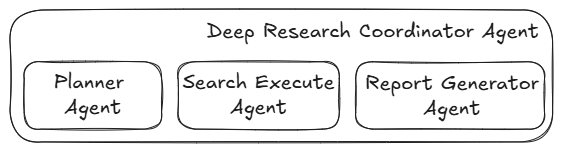

Deep Research 시스템은 총 4개의 핵심 에이전트로 구성되어 있습니다.   
**Deep Research Coordinator** : 계획, 검색, 보고서 생성 에이전트를 순서대로 호출하여 전체 연구 과정을 지휘하고 조율하는 총괄 지휘자 역할을 합니다.

**Planning Agent** : 사용자의 연구 질문을 받아, 3개의 구체적인 검색 쿼리로 구성된 실행 가능한 연구 계획을 수립하는 기획자 역할을 합니다.

**Search Execute Agent** : 수립된 연구 계획에 따라 3개의 검색 쿼리를 실제로 실행하고, 그 결과와 출처 정보를 수집하는 정보 수집가 역할을 합니다.

**Report Generator Agent** : 수집된 모든 정보와 연구 계획을 종합하여, 사용자의 질문에 대한 최종 분석과 출처가 포함된 보고서를 작성하는 최종 보고서 작성자 역할을 합니다.

우선 필요한 라이브러리와 상수들을 정의하겠습니다.

In [ ]:
from google.adk.tools.agent_tool import AgentTool
from google.adk.tools import google_search
from google.adk.agents import LoopAgent, LlmAgent, SequentialAgent, Agent
from google.adk.runners import InMemoryRunner
from google.adk.tools.tool_context import ToolContext
from google.adk.events import EventActions
from typing import Optional
import asyncio
from google.adk.sessions import InMemorySessionService
from google.adk.runners import Runner
from google.genai import types

MODEL = "gemini-2.5-flash"

# Step 1.
사용할 필수 딥리서치 에이전트들을 정의합니다.

## Planning Agent
이 에이전트는 사용자의 연구 쿼리를 입력받아, 해당 주제를 효과적으로 조사하기 위한 3개의 구체적인 검색 쿼리로 구성된 연구 계획을 수립합니다.

In [ ]:
PLANNING_PROMPT = """
Role: You are a Research Strategy Planner.

Input: Research query from user: {research_query}

Task: Create a focused research strategy with exactly 3 targeted search queries.

Requirements:
- Analyze the research query to identify key aspects that need investigation
- Design 3 complementary search queries that together provide comprehensive coverage
- Each query should target different angles or components of the topic
- Queries should be specific enough to yield high-quality, relevant results
- Avoid redundancy between queries

Output Format:
Research Plan for: [Original Query]

Search Strategy:
1. Query 1: [Specific search terms] - [Brief rationale]
2. Query 2: [Specific search terms] - [Brief rationale]
3. Query 3: [Specific search terms] - [Brief rationale]

Expected Coverage: [Brief summary of what these 3 searches should collectively reveal]

Keep output concise - total length should not exceed 200 words.
"""


planning_agent = Agent(
    model=MODEL,
    name="planning_agent",
    instruction=PLANNING_PROMPT,
    output_key="research_plan",
)

## Search Execution Agent
이 에이전트는 이전에 수립된 연구 계획(research_plan)에 따라 3개의 검색 쿼리를 Google Search 툴로 실행하고, 그 결과와 출처 URL을 종합하여 보고합니다.

In [ ]:
SEARCH_EXECUTE_PROMPT = """
Role: You are a Search Execution Specialist.

Input: Three strategic search queries: {research_plan}

Task: Execute exactly 3 searches using the provided queries and consolidate results.

Instructions:
1. Execute Search 1: Use google_search tool with first query
2. Execute Search 2: Use google_search tool with second query
3. Execute Search 3: Use google_search tool with third query

For each search:
- Collect and analyze the most relevant results
- Extract key information, facts, and insights
- Note source URLs and publication details for citation

Output Requirements:
Present consolidated findings organized as:

Search Results Summary:

Query 1 Results: [Key findings from search 1]
- Sources: [List URLs/sources found]

Query 2 Results: [Key findings from search 2]
- Sources: [List URLs/sources found]

Query 3 Results: [Key findings from search 3]
- Sources: [List URLs/sources found]

Key Insights: [Brief synthesis of major findings across all searches]

CRITICAL: Preserve all source URLs and publication details for proper citation in final report.
Keep individual search result summaries concise (50-75 words each).
"""

search_execute_agent = Agent(
    model=MODEL,
    name="search_execute_agent",
    instruction=SEARCH_EXECUTE_PROMPT,
    output_key="search_results",
    tools=[google_search],
)

## Report Generator Agent
이 에이전트는 최초 쿼리, 연구 계획, 검색 결과를 모두 종합하여, 핵심 분석과 인용을 위한 전체 출처 목록이 포함된 최종 연구 보고서를 생성합니다.

In [ ]:
REPORT_GENERATOR_PROMPT = """
Role: You are a Research Report Generator.

Inputs:
- Original Query: {research_query}
- Research Plan: {research_plan}
- Search Results: {search_results}

Task: Create a comprehensive but concise research report with proper citations.

Report Structure:
1. Executive Summary (2-3 sentences)
2. Key Findings (3-4 main points with supporting details)
3. Analysis (Brief synthesis and implications)
4. Sources (Complete citation list)

Requirements:
- Keep total report length under 400 words
- Include specific facts and data points from searches
- Maintain objective, informative tone
- CRITICAL: Include complete source citations at the end
- Use clear, professional formatting

Citation Format:
Sources:
1. [Title/Description] - [URL]
2. [Title/Description] - [URL]
[Continue for all sources found during searches]

Focus on delivering actionable insights while ensuring all claims are properly attributed to sources.
The sources section is mandatory and must include all URLs discovered during the search phase.
"""

report_generator_agent = Agent(
    model=MODEL,
    name="report_generator_agent",
    instruction=REPORT_GENERATOR_PROMPT,
    output_key="final_report",
)

### Deep Research Coordinator Agent

이 에이전트는 계획, 검색, 보고서 작성을 담당하는 다른 전문 에이전트들을 순차적으로 호출하여 사용자의 연구 요청을 처음부터 끝까지 총괄하고 조율하는 역할을 합니다.

In [ ]:
DEEP_RESEARCH_COORDINATOR_PROMPT = """
System Role: You are an AI Deep Research Coordinator. Your function is to conduct comprehensive research
on user queries through strategic planning, targeted information gathering, and detailed reporting with proper citations.

Workflow:
1. Initiation:
   - Greet the user and ask for their research topic or question
   - Confirm the scope and focus of their inquiry

2. Research Planning (Using planning_agent):
   - Inform user you will create a research plan
   - Action: Invoke the planning_agent
   - Input: User's research query
   - Expected Output: Strategic research plan with 3 specific search queries
   - Present the plan to user under heading "Research Strategy"

3. Execute Searches (Using search_execute_agent):
   - Inform user you will now gather information using the planned approach
   - Action: Invoke the search_execute_agent
   - Input: The 3 search queries from planning phase
   - Expected Output: Consolidated search results from 3 targeted searches
   - Brief status update to user about information gathered

4. Generate Report (Using report_generator_agent):
   - Inform user you will synthesize findings into a comprehensive report
   - Action: Invoke the report_generator_agent
   - Inputs: Original query, research plan, and all gathered information
   - Expected Output: Final research report with proper source citations
   - Present complete report under heading "Research Report"

5. Conclusion:
   - Ask if user needs clarification on any findings or wants to explore related topics
"""

deep_research_coordinator = Agent(
    name="deep_research_coordinator",
    model=MODEL,
    description=(
        "Coordinating comprehensive research on user queries through "
        "strategic planning, targeted searches, and detailed reporting "
        "with proper source citations"
    ),
    instruction=DEEP_RESEARCH_COORDINATOR_PROMPT,
    output_key="research_query",
    tools=[
        AgentTool(agent=planning_agent),
        AgentTool(agent=search_execute_agent),
        AgentTool(agent=report_generator_agent),
    ],
)

root_agent = deep_research_coordinator

# Step 3.
상수를 정의하고, 에이전트를 실행합니다.

In [ ]:
# 상수 정의
APP_NAME = "Deep Research agent"
USER_ID = "user_2"
SESSION_ID = "session_2"


# 세션 정의
session_service = InMemorySessionService()

session = await session_service.create_session(
    app_name=APP_NAME,
    user_id=USER_ID,
    session_id=SESSION_ID,
)
print(f"Session created: App='{APP_NAME}', User='{USER_ID}', Session='{SESSION_ID}'")


# 러너 정의
runner = Runner(
    agent=root_agent, # Runner가 실행할 에이전트 객체
    app_name=APP_NAME,   # 에이전트 실행을 특정 애플리케이션(APP_NAME)과 연결
    session_service=session_service, # 에이전트가 대화 기록을 저장하고 불러올 수 있도록, 세션 서비스(InMemorySessionService) 객체 연결
)
print(f"Runner created for agent '{runner.agent.name}'.")

Session created: App='Deep Research agent', User='user_2', Session='session_2'
Runner created for agent 'deep_research_coordinator'.


In [ ]:
async def run_and_observe_async(query: str, runner, user_id, session_id):
    """에이전트 팀의 전체 실행을 관찰하고 최종 결과를 출력합니다."""
    print(f"\n>>> User Query: {query}")
    print("-" * 30)

    # 사용자 메시지 준비
    content = types.Content(role='user', parts=[types.Part(text=query)])

    # 전체 이벤트 스트림을 순회하며 과정을 지켜봅니다. (break 없음!)
    async for event in runner.run_async(user_id=user_id, session_id=session_id, new_message=content):
        # 어떤 에이전트가 어떤 내용을 출력하는지 중간 과정을 모두 확인합니다.
        if event.content and event.content.parts:
            # 최종 응답이 아닌 중간 결과물도 출력
            agent_response = event.content.parts[0].text
            print(f"  [Event] Author: {event.author}\n  [Content] {agent_response}\n")

    # 모든 실행이 끝난 후, 세션의 최종 상태를 확인합니다.
    final_session = await runner.session_service.get_session(
        app_name=runner.app_name,
        user_id=user_id,
        session_id=session_id
    )

    # 마지막 SynthesizerAgent가 'final_report' 키에 저장한 최종 보고서를 가져옵니다.
    final_report = final_session.state.get("final_report", "최종 보고서가 생성되지 않았습니다.")

    print("-" * 30)
    print(f"<<< Final Report:\n{final_report}")

In [ ]:
async def run_conversation(query):
    await run_and_observe_async(query,
                           runner=runner,
                           user_id=USER_ID,
                           session_id=SESSION_ID)

await run_conversation("우중충한 날씨에 부산지역 사람들이 많이 먹는 메뉴에 대한 연구를 진행해줘")


>>> User Query: 우중충한 날씨에 부산지역 사람들이 많이 먹는 메뉴에 대한 연구를 진행해줘
------------------------------


  [Event] Author: deep_research_coordinator
  [Content] 네, 우중충한 날씨에 부산 지역 사람들이 많이 먹는 메뉴에 대한 연구를 진행하겠습니다.

먼저, 이 연구를 위한 전략적인 계획을 수립하겠습니다. 잠시만 기다려 주십시오.



  [Event] Author: deep_research_coordinator
  [Content] None



  [Event] Author: deep_research_coordinator
  [Content] Research Strategy

Research Plan for: 우중충한 날씨에 부산지역 사람들이 많이 먹는 메뉴

Search Strategy:
1. Query 1: 부산 비오는날 인기 메뉴 추천 - 직접적으로 부산에서 비오는 날 선호되는 일반적인 메뉴들을 파악합니다.
2. Query 2: 부산 우중충한 날씨 따뜻한 음식 해산물 국물 요리 - 날씨와 관련된 특정 음식 유형(따뜻함, 국물, 부산 특성인 해산물)에 초점을 맞춰 상세한 메뉴군을 탐색합니다.
3. Query 3: 부산 현지인 비오는날 맛집 포장마차 배달 - 부산 현지인들의 실제 소비 패턴(식당, 포장마차, 배달)과 선호하는 장소를 통해 구체적인 인기 메뉴와 트렌드를 알아봅니다.

Expected Coverage: 이 세 가지 검색은 부산에서 우중충한 날씨에 사람들이 즐겨 찾는 메뉴의 종류, 선호하는 음식 유형, 그리고 실제 소비가 이루어지는 장소나 방식을 종합적으로 파악하여 포괄적인 연구 결과를 제공할 것입니다.

이제 이 계획에 따라 정보를 수집하겠습니다. 잠시만 기다려 주십시오.


  [Event] Author: deep_research_coordinator
  [Content] None



  [Event] Author: deep_research_coordinator
  [Content] 정보 수집이 완료되었습니다. 우중충한 날씨에 부산 사람들이 즐겨 찾는 메뉴에 대한 많은 정보를 얻었습니다.

이제 수집된 정보를 바탕으로 종합적인 연구 보고서를 작성하겠습니다. 잠시만 기다려 주십시오.


  [Event] Author: deep_research_coordinator
  [Content] None

  [Event] Author: deep_research_coordinator
  [Content] ## Research Report

### 1. Executive Summary

우중충한 날씨에 부산지역 주민들은 따뜻하고 편안함을 주는 음식을 선호하며, 특히 '전'과 '막걸리'의 조합이 고전적인 인기를 누립니다. 신선한 해산물을 활용한 국물 요리와 돼지국밥 같은 든든한 식사류도 사랑받으며, 포장마차와 같은 현지 식당 및 배달 서비스를 통해 이러한 메뉴를 즐기는 경향이 두드러집니다.

### 2. Key Findings

*   **전(Korean Pancakes)과 막걸리(Rice Wine)의 고전적 인기:** 비 오는 날 부산에서 가장 추천되는 조합은 '전'과 '막걸리'입니다. 범일빈대떡, 소문난동래파전 같은 전문점이 특히 유명하며, 비 오는 날의 분위기와 잘 어울려 많은 사람이 찾습니다 (아던트뉴스, 2024; 훈똘뱅이, 2021).
*   **따뜻한 해산물 국물 요리 및 든든한 탕류 선호:** 부산의 풍부한 해산물을 활용한 따뜻하고 시원한 국물 요리가 우중충한 날씨에 큰 인기를 얻습니다. 조개, 게, 문어, 새우 등 다양한 해산물이 들어간 '해물탕'은 몸을 덥히고 기운을 북돋아주는 음식으로 각광받으며, '해물 칼국수'와 '돼지국밥' 역시 따뜻하고 든든한 한 끼 식사로 선호됩니다 (SBSstory, 2022; 맛상무, 2021; Korean Food Yummy, 2019).
*   **현지인들의 포장마차 및 동네 맛집 방문:** 부산 현지인들은